In [1]:
# All dependencies
import sys
import requests
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

from os import path
from time import time
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D as plt3

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as tts, cross_validate, GridSearchCV as GSCV

# important global constants
global default_data_percentage
default_data_percentage = 1

**Commonly Used Methods**

The methods below are commonly used when running a variety of classification and regression models.

**Culling the Accidents Data**

In the `accidents.csv` file, we found that there was too much data accidents of severity 2 and three recorded, leading to nearly unreadable graphs and an unusually high accuracy.  As a result, a method was created to ensure the number of all accidents was roughly even across all severities.

In [2]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

def get_mean_absolute_error(y, y_pred):
    return np.mean(np.absolute(np.asarray(y) - np.asarray(y_pred)))

def cull_data(dataset, features, percent_of_even_data_to_use=default_data_percentage):
    accident_data = data_frames[dataset][features].dropna().values
    np.random.shuffle(accident_data)
    
    unique_labels, unique_label_counts = np.unique(accident_data[:, -1], return_counts = True)
    returning_accident_data = accident_data[accident_data[:, -1] == unique_labels[0]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]
    for l in range(1, len(unique_labels)):
        returning_accident_data = np.vstack((returning_accident_data, accident_data[accident_data[:, -1] == unique_labels[l]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]))
    
    np.random.shuffle(returning_accident_data)
    return returning_accident_data

def mult_list(val_list):
    product = len(val_list[0])

    for val in val_list:
        product *= len(val_list)

    return product

def count_iters(params):
    param_lens = [len(val) for _, val in params.items()]
    return sum(param_lens) + mult_list(param_lens)
    

def custom_cv(estimators, X, y, params_list, scoring = 'accuracy', test_size=0.3, seed=42, timed=True, verbose=False):
    if timed: start_time = time()

    ret_dict = {}
    X_train, X_test, y_train, y_test = tts(X, y, test_size=test_size, random_state=seed)

    if len(estimators) != len(params_list):
        print("The number of estimators and corresponding parameters does not match")
        return
        
    for a in range(len(estimators)):
        estimator_name = estimators[a].__class__.__name__
        if timed: individual_time = time()
        pipe = Pipeline([("scaler", SS()), ("gscv", GSCV(estimators[a], params_list[a], scoring = scoring, verbose=1 if verbose else 0))])
        pipe.fit(X_train, y_train)
        
        if scoring == 'neg_mean_absolute_error':
            ret_dict[estimator_name] = {
                "best_mae": get_mean_absolute_error(y_test, pipe.predict(X_test)),
                # "best_estimator": pipe.named_steps["gscv"].best_estimator_,
                "best_params": pipe.named_steps["gscv"].best_params_,
                "best_score": pipe.named_steps["gscv"].best_score_,
            }
        else:
            ret_dict[estimator_name] = {
                "best_accuracy": get_accuracy(y_test, pipe.predict(X_test)),
                # "best_estimator": pipe.named_steps["gscv"].best_estimator_,
                "best_params": pipe.named_steps["gscv"].best_params_,
                "best_score": pipe.named_steps["gscv"].best_score_,
            }

        if timed: ret_dict[estimator_name]["fit_time"] = time() - individual_time
        if verbose and timed: print(f"{estimator_name} fit time: {ret_dict[estimator_name]['fit_time']:.3f} seconds")

    if timed: ret_dict["total_time"] = time() - start_time
    if verbose and timed: print(f"Total Cross Validation fit time: {ret_dict['total_time'] / 60:.3f} minutes")

    return ret_dict

def print_cv_results(cust_cv_results, precision=3, problem_type = "classification"):
    for key, results_dict in cust_cv_results.items():
        if not isinstance(results_dict, dict):
            continue
            
        print(f"Showing results of Grid Search and Cross Validation for: {key}")
        print(f"\tBest Params: {results_dict['best_params']}")
        print(f"\tBest Score: {results_dict['best_score']:.{precision}f}")
        if problem_type == "regression":
            print(f"\tFinal {key} Mean Absolute Error: {results_dict['best_mae']:.{precision}f}")
        else:
            print(f"\tFinal {key} Accuracy: {results_dict['best_accuracy']:.{precision}f}%")
        try:
            print(f"\t{key} Fit Time: {results_dict['fit_time']:.{precision}f} seconds\n")
        except KeyError:
            print()

    try:
        print(f"Total time to fit all classifiers: {cust_cv_results['total_time'] / 60:.{precision}f} minutes")
    except KeyError:
        pass

**Downloading of the Data Files**

We used dropbox to store the CSV files and used their urls to load them into pandas Dataframes using our custom method `dataframe_from_csv`.
To save load time, if the method first checks if the datasets are already downloading before attempting to download from the dropbox.

In [3]:
# Download data files
def load_datasets(combined=False):
    urls = {
        "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
        "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
        "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
        "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
    }

    ret_frames = {}

    exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
    valid_datasets = list(urls.keys())[:-1]
    for file_name in valid_datasets:
        print(f"Loading {file_name}.csv")
        if path.exists(f"{file_name}.csv"):
            ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
            continue
        
        direct_url = urls[file_name].replace("&dl=0", "&dl=1")
        response = requests.get(direct_url)

        with open(f"{file_name}.csv", "wb") as f:
            f.write(response.content)
            print(f"Wrote {file_name}.csv")

        ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

    if combined:
        print("Creating combined table")
        ret_frames["combination"] = pd.concat([ret_frames[name] for name in valid_datasets], axis=1)

    return ret_frames

data_frames = load_datasets(combined=True)
print("Done!")

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Creating combined table
Done!


## Method
We approached testing each classifier for all classification problems by using Grid Search combined with Cross Validation on our culled dataset to obtain the best parameters for each classifier.

In [4]:
def run_classifier_models(dataset, features, percent_of_even_data_to_use):
    accident_data = cull_data(
        dataset,
        features, 
        percent_of_even_data_to_use
    )

    X = accident_data[:, :-1]
    y = accident_data[:, -1]
    
    plot_ftrs(X, y, dimensions=2)
    
    svc_params = {
        "kernel": ["linear", "rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "gamma": [0.001, 0.01, 0.1, 1, 10],
    }
    rfc_params = {
        "n_estimators": [1, 10, 100, 1000]
    }
    knn_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80]
    }

    results = custom_cv([SVC(), RFC(), KNN()], X, y, params_list=[svc_params, rfc_params, knn_params], scoring = 'accuracy', verbose=True)
    print_cv_results(results, precision=4)
    return accident_data, X, y

In [5]:
def create_feature_pair_plot(accident_data, feature_names, labels, index_of_first_feature, index_of_second_feature):
    plt.scatter(accident_data[:, index_of_first_feature], accident_data[:, index_of_second_feature], c=labels, cmap="viridis", alpha=0.75)
    plt.xlabel(feature_names[index_of_first_feature])
    plt.ylabel(feature_names[index_of_second_feature])
    plt.show()

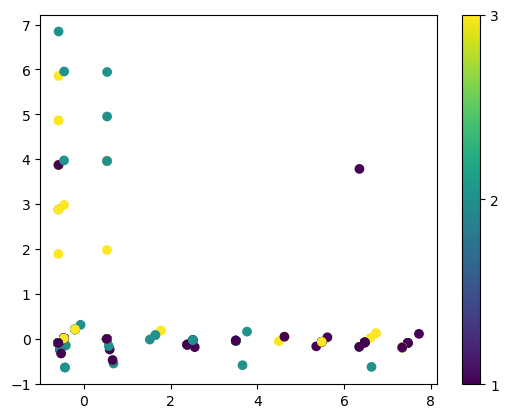

Fitting 5 folds for each of 50 candidates, totalling 250 fits
SVC fit time: 20.514 seconds
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier fit time: 17.809 seconds
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNeighborsClassifier fit time: 0.585 seconds
Total Cross Validation fit time: 0.648 minutes
Showing results of Grid Search and Cross Validation for: SVC
	Best Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
	Best Score: 0.3415
	Final SVC Accuracy: 89.5420%
	SVC Fit Time: 20.5137 seconds

Showing results of Grid Search and Cross Validation for: RandomForestClassifier
	Best Params: {'n_estimators': 1000}
	Best Score: 0.3415
	Final RandomForestClassifier Accuracy: 89.4150%
	RandomForestClassifier Fit Time: 17.8095 seconds

Showing results of Grid Search and Cross Validation for: KNeighborsClassifier
	Best Params: {'n_neighbors': 8}
	Best Score: 0.3538
	Final KNeighborsClassifier Accuracy: 90.5730%
	KNeighborsClassifier Fit Time: 0.5850

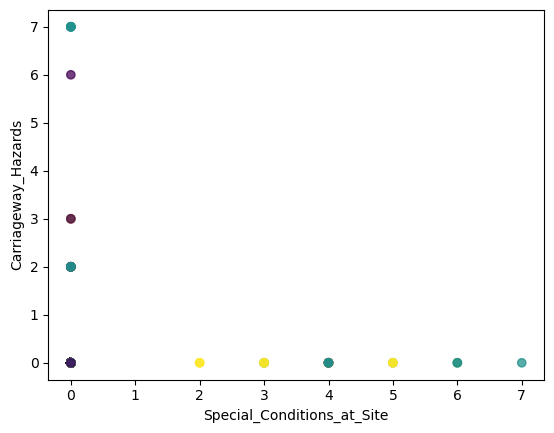

In [6]:
# First Question: How does the weather impact the serverity of the accident?
feature_names = ["Weather_Conditions", "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
accident_data, X, y = run_classifier_models("accidents", feature_names, 0.02)
print("Now expermenting with pairs of features.")
create_feature_pair_plot(accident_data, feature_names, y, 2, 3)

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN_REG

def cull_data_for_regression(dataset, features, percent_of_even_data_to_use=default_data_percentage):
    accident_data = data_frames[dataset][features].dropna().values
    np.random.shuffle(accident_data)
    returning_accident_data = accident_data[:int(len(accident_data) * percent_of_even_data_to_use)]
    np.random.shuffle(returning_accident_data)
    return returning_accident_data

def run_random_forest_regression(n_estimators, X, y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    rf_reg = RandomForestRegressor(n_estimators = n_estimators)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    plt.scatter(X_test[:, 0], y_test, color = 'blue', alpha=0.5, label = 'data')
    plt.plot(X_test[:, 0], y_pred, color='red', alpha=0.8,linewidth=2, label = 'model')
    plt.title("Random Forest Plot")
    plt.show()
    return get_mean_absolute_error(y_test, y_pred)

def run_knn_regression(n_neighbors, X, y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    knn_reg = KNN_REG(n_neighbors = n_neighbors)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    plt.scatter(X_test[:, 0], y_test, color = 'blue', alpha=0.5, label = 'data')
    plt.plot(X_test[:, 0], y_pred, color='red', alpha=0.8,linewidth=2, label = 'model')
    plt.title("K Nearest Neighbors Plot")
    plt.show()
    return get_mean_absolute_error(y_test, y_pred)

In [8]:
def run_regression_cv(dataset, features, percent_of_even_data_to_use):
    accident_data = cull_data_for_regression(
        dataset,
        features, 
        percent_of_even_data_to_use
    )
    
    X = accident_data[:, :-1]
    y = accident_data[:, -1]
    
    #plot_ftrs(X, y, dimensions=2)
    
    rfr_params = {
        "n_estimators": [1, 10, 100, 1000]
    }
    knnr_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80]
    }

    results = custom_cv([RandomForestRegressor(), KNN_REG()], X, y, params_list=[rfr_params, knnr_params], scoring = 'neg_mean_absolute_error', verbose=True)
    print_cv_results(results, precision=4, problem_type = "regression")
    return results, accident_data, X, y

In [9]:
def run_regression_models(dataset, features, percent_of_even_data_to_use):
    results, accident_data, X, y = run_regression_cv(dataset, features, percent_of_even_data_to_use)
    run_random_forest_regression(results["RandomForestRegressor"]["best_params"]["n_estimators"], X, y)
    run_knn_regression(results["KNeighborsRegressor"]["best_params"]["n_neighbors"], X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestRegressor fit time: 54.500 seconds
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNeighborsRegressor fit time: 0.479 seconds
Total Cross Validation fit time: 0.916 minutes
Showing results of Grid Search and Cross Validation for: RandomForestRegressor
	Best Params: {'n_estimators': 1000}
	Best Score: -15.9206
	Final RandomForestRegressor Mean Absolute Error: 17.3914
	RandomForestRegressor Fit Time: 54.4995 seconds

Showing results of Grid Search and Cross Validation for: KNeighborsRegressor
	Best Params: {'n_neighbors': 80}
	Best Score: -14.9101
	Final KNeighborsRegressor Mean Absolute Error: 15.4959
	KNeighborsRegressor Fit Time: 0.4790 seconds

Total time to fit all classifiers: 0.9163 minutes


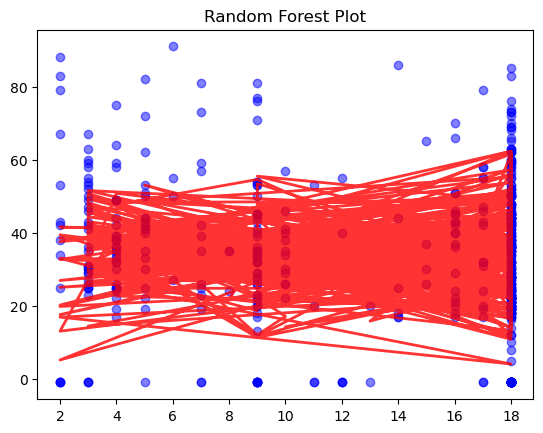

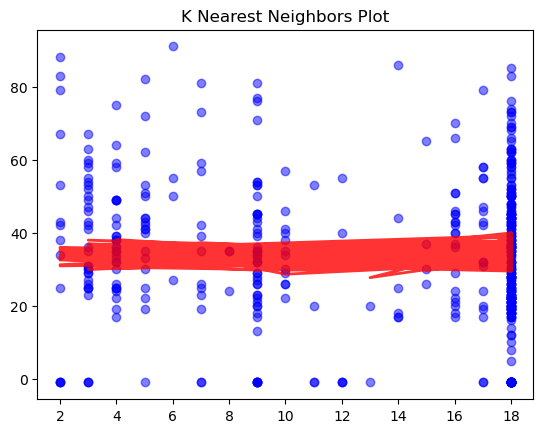

In [10]:
run_regression_models("combination", ["Vehicle_Manoeuvre", "Carriageway_Hazards", "Junction_Control", "Age_of_Casualty", "Accident_Severity", "Casualty_Severity", "Pedestrian_Location", "Pedestrian_Movement", "Age_of_Driver"], 0.001)